In [8]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from sympy.plotting import plot
import operator
from IPython.display import Image
from IPython.core.display import HTML 

###### System of Equations

Full Commitment:
\begin{align}
\dot{k} &= k^\alpha - \left(\delta + n + x\right)k - c\\
\dot{c} &= c\left(\alpha k^{\alpha - 1} - \left(\delta + x\right) - \left(\rho + be^{-\gamma t}\right) \right)
\end{align}

No Commitment:
\begin{align}
\dot{k} &= k^\alpha - \left(\delta + n + x\right)k - c\\
\dot{c} &= c\left(\alpha k^{\alpha - 1} - \left(\delta + x + \lambda\right) \right)
\end{align}

###### Jacobian of the System

$$J(k,c)=
\begin{bmatrix}
\alpha k^{\alpha-1}-\left(\delta+n+x\right) & -1\\
\alpha(\alpha-1)ck^{\alpha-2} & \alpha k^{\alpha - 1} - \left(\delta + x\right) - \left(\rho + be^{-\gamma t}\right)\\
\end{bmatrix}$$


When the Jacobian is at a steady state the $$\rho + be^{-\gamma t}$$ will be 0 as t approaches infinity.  

$$J(k,c)=
\begin{bmatrix}
\alpha k^{\alpha-1}-\left(\delta+n+x\right) & -1\\
\alpha(\alpha-1)ck^{\alpha-2} & 0\\
\end{bmatrix}$$


Through this we can find the eigenvalues and eigenvectors of the Jacobian matrix to check the stability of the system as  it is centered at the steady state. 

In [9]:
def nullcline_intersection(sys, r):
    x, y = sp.symbols('x, y')
    eq1 = sys(x, y, r)[0]
    eq2 = sys(x, y, r)[1]
    sols = sp.solve([eq1, eq2], [x, y])
    return np.array(sols,dtype=float)

In [10]:
def jacsys(k,c,r):
    alpha, delta, xt, n, rho, b, gamma = r[0], r[1], r[2], r[3], r[4], r[5], r[6]
    J = np.array([[alpha*k**(alpha-1)-(delta+xt+n), -1],
    [c*alpha*(alpha-1)*k**(alpha-2), 0]])
    return J

In [11]:
# Use the RK4 solver to complete Linearizing the Jacobian 
def rk4(t,y,h,func,J):
    k1 = h*func(t,y,J)
    k2 = h*func(t+0.5*h,y+0.5*k1,J)
    k3 = h*func(t+0.5*h,y+0.5*k2,J)
    k4 = h*func(t+h,y+k3,J)
    return (k1 + 2*k2 + 2*k3 + k4)/6

# Homebrew Solver: Euler's Method
def rk4_solve(t0,tf,h,y0,func,J):
    tv, yv, = [], []
    t, y = t0, y0
    while t < tf:
        y += rk4(t,y,h,func,J)
        t += h
        yv.append(y.copy())
        tv.append(t)
    return np.array(tv), np.array(yv)

# Take the values close to the steady-point to see the stability around each point placed in J
def F(t,U,J):
    # System of Equations
    return np.array([ J[0,0]*U[0] + J[0,1]*U[1],
                      J[1,0]*U[0] + J[1,1]*U[1]])

###### Values Used

Values of this problem are shown around the original first column values in Barrows table.

The kzed, czed and kinf, cinf are calculated by linearizing \dot{k}, \dot{c}.

In [14]:
alpha, delta, xt, n, rho, b, gamma = 0.75, 0.05, 0.02, 0.01, 0.02, 0.5, 0.5
r = (alpha, delta, xt, n, rho, b, gamma)
lam = .03653

# Equations of k*_0 and c*_0 for No Commitment
kzed = (alpha/(delta + lam + xt))**(1/(1-alpha)) 
czed = kzed**alpha - (delta + n + xt)*kzed 

# Equations of k*_inf and c*_inf for Full Commitment
kinf = (alpha/(delta + rho + xt))**(1/(1-alpha)) 
cinf = kinf**alpha - (delta + n + xt)*kinf

###### Based on the Commitment Type we are able to analyze the different stabilities created by the different states. 

To analyze a different commitment, simply change the CommitmentType, True represents the Full Commitment and False represents No Commitment. 

In each case the derivative of that equations is used to set up their specific Jacobian using the correct steady-state and derivatives. 

###### The Eigenvalues
Based on the eigenvalues of the Jacobian we are able to see how the area around the steady-state will react, whether it is stable, semi-stable, or unstable. The eigenvalues having a switched sign (one positive, one negative), it shows this problem is semi-stable, with a saddle point. 

This can be analyzed by the converging or diverging of the values to and away from the the centeralized steady point. 

In [69]:
# To Test Full or No Commitment change below
# True = Full Commitment 
# False = No Commitment
CommitmentType = True

if CommitmentType:    
    # Jacobian of the Full Comittment Case
    def dFull(k,c,r):
        alpha, delta, xt, n, rho, b, gamma = r[0], r[1], r[2], r[3], r[4], r[5], r[6]
        G1 = k**alpha - (delta+xt+n)*k - c
        G2 = c*(alpha*k**(alpha-1) - (delta+xt) - rho) # b*exp(-gamma*t) -> 0 as t -> infty
        return [G1, G2]
    
    eq = nullcline_intersection(dFull,r)
    Jacobian = jacsys(kinf,cinf,r) 
    Jentries = np.array([[Jacobian[0,0],Jacobian[0,1]],[Jacobian[1,0],Jacobian[1,1]]])
    print("The Full Commitment Case:")
    
else:
    # Jacobian of the No Comittment Case
    def dNo(k,c,r):
        alpha, delta, xt, n, rho, b, gamma = r[0], r[1], r[2], r[3], r[4], r[5], r[6]
        G1 = k**alpha - (delta+xt+n)*k - c
        G2 = c*(alpha*k**(alpha-1) - (delta+xt) - lam)
        return [G1, G2]
    
    eq = nullcline_intersection(dNo,r)
    Jacobian = jacsys(kzed,czed,r)
    Jentries = np.array([[Jacobian[0,0],Jacobian[0,1]],[Jacobian[1,0],Jacobian[1,1]]])
    print("The No Commitment Case:")

print("The Jacobian Matrix of the No Committment case:")
print(Jacobian)
print(" ")
ew, ev = np.linalg.eig(Jacobian)
print('The Eigenvalues: {}'.format(ew))
print('The Eigenvectors: {}'.format(ev))

The Full Commitment Case:
The Jacobian Matrix of the No Committment case:
[[ 1.e-02 -1.e+00]
 [-9.e-04  0.e+00]]
 
The Eigenvalues: [ 0.03541381 -0.02541381]
The Eigenvectors: [[ 0.99967723  0.99937352]
 [-0.02540561  0.03539163]]


###### Plotting the values about the steady-state that is centered around [0,0]. 

Through the use of the RK4 solver, by taking values from the the four quadrants about the steady-state of each No and Full Commitment case, we are able to see the stability of each of these areas.

Each of these quadrands are shown below, with the line highlighted in different colors. The green dots represent the original value of where the line starts and how it vears to the steady point or moves away.

Due to the graph structure, each of these lines look as though they are straight, although when zoomed into each line it is easier to see the curvature of each values stability.  

Full Commitment Case:


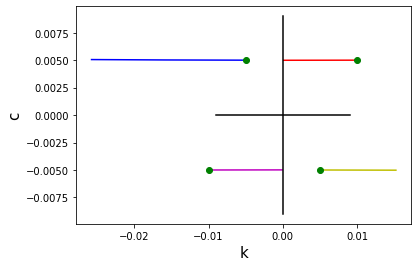

In [63]:
UpLfQ = [-0.005, .005]  # Value in upper left quadrant (Blue)
UpRtQ = [0.01, .005]   # Value in upper right quadrant (Red)
LwLfQ = [-0.01, -0.005] # Value in lower left quadrantn(Purple)
LwRtQ = [0.005, -0.005]  # Value in lower right quadrant (Yellow)


t,v = rk4_solve(0,4,1e-2, UpLfQ,F,Jentries)
t2,v2 = rk4_solve(0,2,1e-2, UpRtQ,F,Jentries)
t3,v3 = rk4_solve(0,2,1e-2, LwLfQ,F,Jentries)
t4,v4 = rk4_solve(0,2,1e-2, LwRtQ,F,Jentries)

if CommitmentType == True:
    print("Full Commitment Case:")
else:
    print("No Commitment Case:")
    
    
plt.plot(v[:,0],v[:,1], 'b',v2[:,0], v2[:,1],'r',v3[:,0], v3[:,1],'m',v4[:,0], v4[:,1],'y',
         [-.009,.009],[0,0],'k',[0,0],[-.009, .009],'k', 
         UpRtQ[0], UpRtQ[1],'go',UpLfQ[0], UpLfQ[1],'go',LwRtQ[0],LwRtQ[1],'go',LwLfQ[0],LwLfQ[1],'go');

plt.xlabel('k',size=15)
plt.ylabel('c',size=15);

#### Showing of the paths about the stable steady-state.

The green circle is the starting point, and the direction the line goes shows the character of how that point reacts around the steady state.

As it is easier to see in these graphs, the North-East and South-West curves verge to the steady state.  While the North-West and South-East move away from the steady-state.

###### Saddle paths for above the stable point.

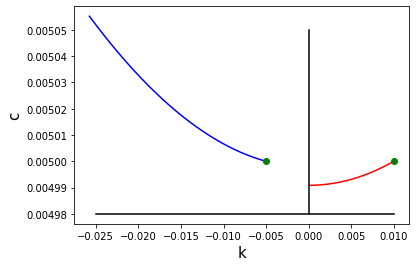

In [64]:
test = plt.plot(v[:,0],v[:,1], 'b', v2[:,0],v2[:,1], 'r',
         [0,0],[0.00498,.00505], 'black', [-.025, .010], [.00498,.00498], 'black',UpRtQ[0],UpRtQ[1],'go',UpLfQ[0],UpLfQ[1],'go');
plt.xlabel('k',size=15)
plt.ylabel('c',size=15);

###### Saddle paths for below the stable point.

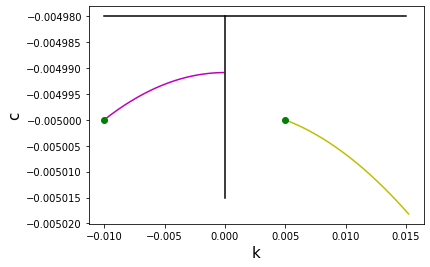

In [65]:
plt.plot(v3[:,0],v3[:,1], 'm', v4[:,0],v4[:,1], 'y',
         [0,0],[-0.00498,-0.005015], 'black', [-.010, .015], [-0.00498,-.00498], 'black', LwRtQ[0],LwRtQ[1],'go',LwLfQ[0],LwLfQ[1],'go');
plt.xlabel('k',size=15)
plt.ylabel('c',size=15);